# Information Retrieval

Information retrieval (IR) in computing and information science is the process of obtaining information system resources that are relevant to an information need from a collection of those resources.

We can make use of these techniques to find the best documents that are related to a question, which is stricly related to out question answering main task. Hece, in this notebook we will vectorize our contexts and questions using TF-IDF and then query on it, where the question is the query and the context is the output.

## Loading of the Dataset

Mount Google Drive and move the working folder to the one containing the dataset (**Note:** this may have to be changed according to the structure of your folders).

In [ ]:
import os
from google.colab import drive

# Mount the Google drive storage
drive.mount('/content/drive')

# Move to the directory with the notebooks and the data set
# (note, you may need to change this path such that it leads to the folder that contains the dataset)
os.chdir('/content/drive/MyDrive')

# Check the currect working directory
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive'

Let's load the data from the json file

In [ ]:
import json
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data['data']

dataset = load_data('train-v2.0.json')

The structure of the training dataset is as follows:
- We have a list of main topics
- Each topic has a title and a list of paragraphs
- Each paragraph consists of a context and a list of questions and answers with the initial position of the first character of the answer in the context

The structure of the validation dataset is the same as that of the training dataset except that given a question we can have more plausible answers for that question, therefore we have a list of answers and start of positions for the first characters

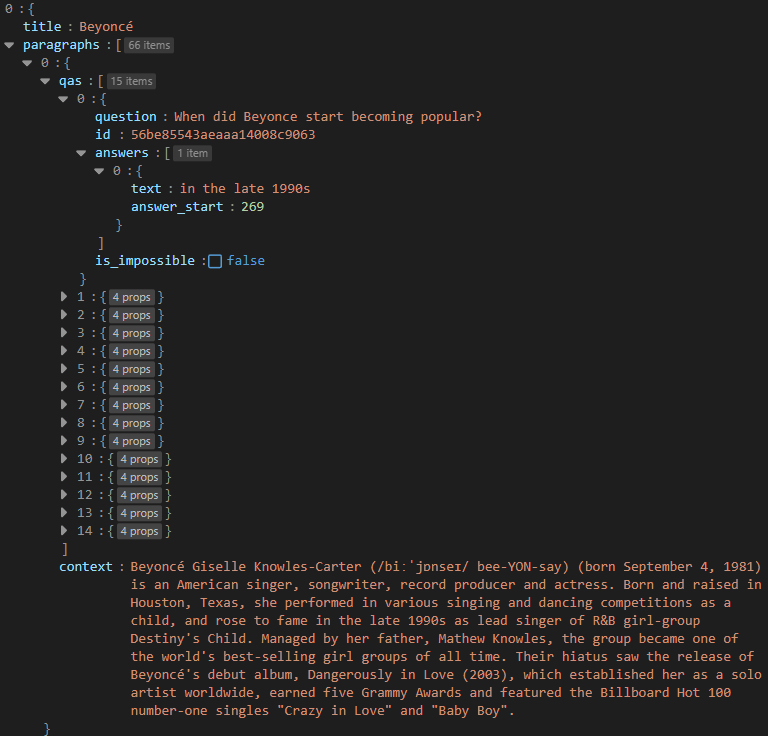


## Vectorization

Let's vectorize the contexts we have just extracted with `TfidfVectorizer` from Scikit-Learn in order to be able to perform clustering.

The tf-idf function is computed as follows: $\mathrm{tfidf}(t, d)=\mathrm{tf}(t, d) \cdot \mathrm{idf}(t)$
where $t$ is the term and $d$ is the document.
- $\mathrm{tf}(t, d)$ is the count of the term $t$ in the document $d$
- $\mathrm{idf}$ is inverse document frequency: $\mathrm{idf}(t) = \log{\frac{n + 1}{\mathrm{df}(t) + 1}} + 1$
- $n$ is the number of documents in collection
- $\mathrm{df}(t)$ is the document frequenci, i.e. the number of documents that contain the term $t$

The parameters of the vectorizer are:
 - `max_df`: ignore terms that have a document frequency strictly higher than the given threshold.
 - `min_df`: ignore terms that have a document frequency strictly lower than the given threshold.
 - `stop_words`: the language considered to remove the stopwords.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

#create list of context

contexts = [paragraph['context'] for sample in dataset for paragraph in sample['paragraphs'] ]
questions = [qas['question'] for sample in dataset for paragraph in sample['paragraphs'] for qas in paragraph['qas'] ]
train_set = contexts + questions #+ answers
print("The train set is long: ", len(train_set))
vectorizer.fit(train_set)
vector_questions = vectorizer.transform(questions)
vector_contexts = vectorizer.transform(contexts)

The train set is long:  149354


We now create a list which associates to each context the number of questions. This will be useful for the next steps.

In [ ]:
num_questions_per_context = [len(paragraph['qas']) for sample in dataset for paragraph in sample['paragraphs']] #this will be used later
print(f"context 0 has {num_questions_per_context[0]} questions associated to it")

context 0 has 15 questions associated to it


## Computation of the Similarities

We can now compute the dot product of each question with all the contexts in the datasets. Then we take the context that best matches each question.

In [ ]:
import numpy as np

question_results = np.dot(vector_questions, vector_contexts.T)
best_matches = np.argmax(question_results, axis=1) #for each question, which is the index of the context (in vector_context) that is most similar to it?
print(f"The more similar context to question 0 is {best_matches[0]}")

The more similar context to question 0 is [[6025]]


Already from the first resut we can see the limitations of this system: the first question is associated with context number 6026, clearly not the one to which it is really associated (the first context).

## Evaluation

We now need a list that associates to each question, the real context associated with it. This can be considered as the ground knowledge for the evaluation part, in contrast with the predictions contained in the results of the previous dot product.

In [ ]:
index_of_context_related_to_question = [] #for each question, which is the index of the context associated to it?
cursor = 0
for i, num_questions in enumerate(num_questions_per_context): #I know that context i has num_questions questions
    for j in range(num_questions): #I take the questions from cursor to cursor+num_questions
        index_of_context_related_to_question.append(i)
    cursor += num_questions #put cursor on so that I go to next set of questions
print("The first 20 entries of index_of_context_related_to_question (note that the first 15 are all 0s): ", index_of_context_related_to_question[0:20])
print("The number of questions associated to the first context: ", num_questions_per_context[0])

The first 20 entries of index_of_context_related_to_question (note that the first 15 are all 0s):  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
The number of questions associated to the first context:  15


Let's now combine the predictions with the ground knowledge to compute some metrics:
 - Accuracy: provides a general measure of how well the classifier performs across all classes by calculating the ratio of correctly predicted samples to the total number of samples: $\mathrm{accurancy} = \frac{tp+tn}{tp + tn + fp + fn}$
 - Precision: measures the ability of the classifier to correctly identify positive instances out of all instances predicted as positive. Hence, it focuses on the quality of the positive predictions: $\mathrm{precision} = \frac{tp}{tp + fp}$
 - Recall: measures the ability of the classifier to correctly identify positive instances out of all actual positive instances: $\mathrm{recall} = \frac{tp}{tp + fn}$

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_pred = np.asarray(best_matches[:,0]).flatten().tolist()
y_true = index_of_context_related_to_question

print("Accurancy: ", accuracy_score(y_true, y_pred))
print("Precision: ", precision_score(y_true, y_pred, average='weighted', zero_division=0))
print("Recall: ", recall_score(y_true, y_pred, average='weighted'))

Accurancy:  0.4005402128622841
Precision:  0.567246943076542
Recall:  0.4005402128622841


These metrics show the limitation of this kind of approach. Tf-idf vectorization doesn't take into account, in fact the semantic of the texts, hence it can only find the documents that are more correlated in terms of vocabulary, leading to wrong prediction in mani cases.

A better approach is to use embeddings (e.g. computed with Bert): this has been done in other notebooks such as Word Embeddings and Question Answering.